In [1]:
import networkx as nx
import numpy as np
import heapq
import math
import random
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import collections
import time
import psutil
import os

In [5]:
def get_memory_usage():
  process = psutil.Process(os.getpid())
  # return the bytes
  return process.memory_info().rss

In [2]:
def bi_bellman_ford(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distances between nodes on the shortest path
  dist_fwd = {node: float('inf') for node in nodes}
  dist_fwd[s] = 0

  dist_back = {node: float('inf') for node in nodes}
  dist_back[t] = 0

  # keep track of how or if we are updating
  # if done updating the algo stops running
  updated_fwd = True
  updated_back = True

  # iterate potentially over all nodes
  for _ in range(len(nodes) - 1):
    mem_usage.append(get_memory_usage())
    if not updated_fwd and not updated_back:
      # if we found the shortest path, iterate no more
      break

    # get ready for a new iteration of updates
    updated_fwd = False
    updated_back = False
    temp_dist_fwd = dist_fwd.copy()
    temp_dist_back = dist_back.copy()

    # check forward edge
    for u, v, weight in G.edges(data='weight'):
      if weight is None:
        continue
      if dist_fwd[u] + weight < temp_dist_fwd[v]:
        # go fwd and check weight fwd
        temp_dist_fwd[v] = dist_fwd[u] + weight
        updated_fwd = True

      # check reverse edge for fwd dist
      if dist_fwd[v] + weight < temp_dist_fwd[u]:
        temp_dist_fwd[u] = dist_fwd[v] + weight
        updated_fwd = True

      if dist_back[u] + weight < temp_dist_back[v]:
        # go from backward and add the weight
        temp_dist_back[v] = dist_back[u] + weight
        updated_back = True

      # check reverse edge from the backward search
      if dist_back[v] + weight < temp_dist_back[u]:
        temp_dist_back[u] = dist_back[v] + weight
        updated_back = True

    # update the forward distances
    dist_fwd = temp_dist_fwd
    # update the backward distances
    dist_back = temp_dist_back

  shortest_path = float('inf')
  for node in nodes:
    if dist_fwd[node] + dist_back[node] < shortest_path:
      # if the fwd dist from source to node + back dist from target to node < shortest_path, update
      shortest_path = dist_fwd[node] + dist_back[node]
  end_time = time.time()

  return shortest_path, (end_time - start_time), np.average(mem_usage)

In [16]:
def bi_dijkstras(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distance between node pairs from the forward search
  fwd_dist = {node: float('inf') for node in nodes}
  fwd_dist[s] = 0

  # keep track of the distance between node pairs from the backward search
  back_dist = {node: float('inf') for node in nodes}
  back_dist[t] = 0

  fwdHeap = [(0, s)]
  backHeap = [(0, t)]

  mu = float('inf')

  fwd_seen = set()
  back_seen = set()

  while fwdHeap and backHeap:
    mem_usage.append(get_memory_usage())

    if mu <= fwdHeap[0][0] + backHeap[0][0]:
      # found the optimal shortest path
      break

    fwd_dist_node, node = heapq.heappop(fwdHeap)
    if node in fwd_seen:
      # we've already found a shorter path to the node using forward iteration
      continue
    fwd_seen.add(node)

    if fwd_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    #iterate over neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if fwd_dist[node] + weight < fwd_dist[nei]:
        fwd_dist[nei] = fwd_dist[node] + weight
        heapq.heappush(fwdHeap, (fwd_dist[nei], nei))

    back_dist_node, node = heapq.heappop(backHeap)
    if node in back_seen:
      # we've already found a shorter path to the node using backward iteration
      continue

    # mark the current node as seen
    back_seen.add(node)
    if back_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    # iterate over the neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if back_dist[node] + weight < back_dist[nei]:
        back_dist[nei] = back_dist[node] + weight
        heapq.heappush(backHeap, (back_dist[nei], nei))


    mu = min(mu, fwd_dist[node] + back_dist[node])

    end_time = time.time()
    after_mem = get_memory_usage()
  return mu, (end_time - start_time), np.average(mem_usage)

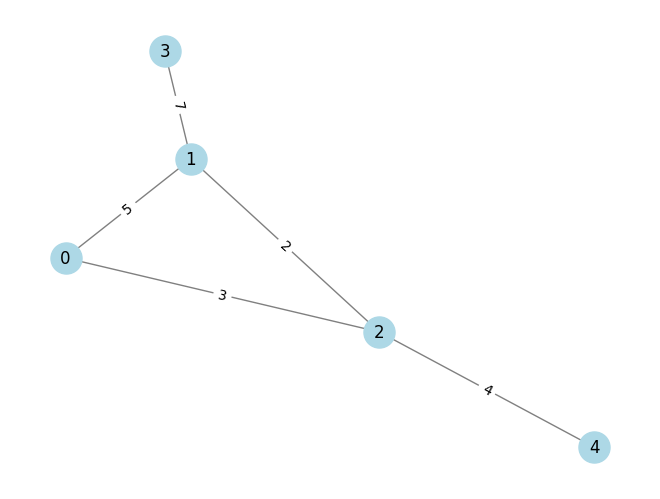

(9, 0.002490997314453125, 205443072.0)
(9, 0.0003421306610107422, 205443072.0)


In [17]:
# Create a simple graph with 5 nodes and some edges
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1, {'weight': 5}), (0, 2, {'weight': 3}), (1, 2, {'weight': 2}), (1, 3, {'weight': 7}), (2, 4, {'weight': 4})])

pos = nx.spring_layout(G)  # Define node positions using spring layout
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

print(bi_bellman_ford(G, 2, 3))
print(bi_dijkstras(G, 2, 3))

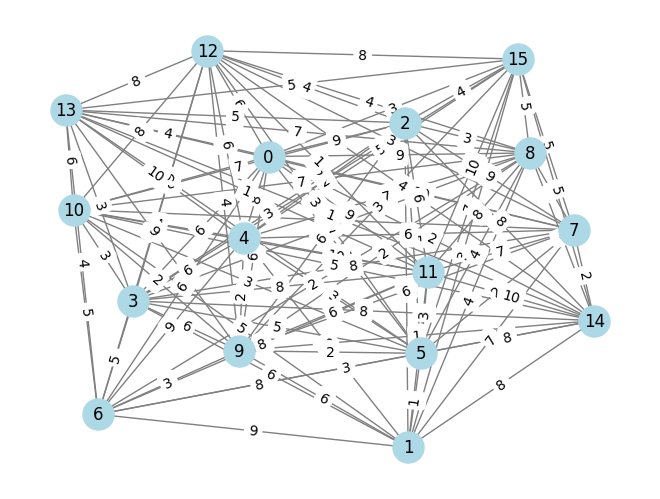

Control Shortest Path: 4
Bi-Di Bellman-Ford Shortest Path: (4, 0.0018162727355957031, 208125952.0)
Bi-Di Dijkstras Shortest Path: (4, 0.00036907196044921875, 208125952.0)


In [19]:
def generate_random_weighted_graph(num_nodes_min=10, num_nodes_max=30, edge_factor_min=2, edge_factor_max=10, weight_min=1, weight_max=10):
  """Generates a random graph with random edge weights."""
  num_nodes = random.randint(num_nodes_min, num_nodes_max)
  num_edges = random.randint(num_nodes * edge_factor_min, num_nodes * edge_factor_max)

  G = nx.gnm_random_graph(num_nodes, num_edges)

  # Add random weights to edges
  for u, v in G.edges():
    G.edges[u, v]['weight'] = random.randint(weight_min, weight_max)

  return G
def test():
  G = generate_random_weighted_graph()

  # Generated with Google Gemini:
  pos = nx.spring_layout(G)  # Define node positions using spring layout
  nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
  edge_labels = nx.get_edge_attributes(G, 'weight')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
  plt.show()
  #end code generation

  source = random.choice(list(G.nodes))
  target = random.choice(list(G.nodes))

  # use the shortest path algo from NX compare against algos
  control_sp = nx.shortest_path_length(G, source=source, target=target, weight='weight')
  bi_bellman_ford_sp = bi_bellman_ford(G, source, target)
  bi_dijkstras_sp = bi_dijkstras(G, source, target)

  print(f"Control Shortest Path: {control_sp}")
  print(f"Bi-Di Bellman-Ford Shortest Path: {bi_bellman_ford_sp}")
  print(f"Bi-Di Dijkstras Shortest Path: {bi_dijkstras_sp}")
test()

heapq.heappush(fwdHeap, (fwd_dist[nei], nei)): if you find a new route to nei, you're apparently adding a new copy of nei to the heap? Seems like it could cause problems unless you're already handling it somewhere. What you'd prefer to do is change the priority of the existing copy of nei that's already in the heap. The doc page https://docs.python.org/3/library/heapq.html#priority-queue-implementation-notes gives an approach if you search "changing its priority".

If we pop a node, and its length is longer than its representation in fwd or bckwd pq, then we stop iteration alleviating the problem